[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [32]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [33]:
# Run this cell and paste the API key in the prompt
import os
import configparser
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the configuration file
config.read('../../.config.ini')
os.environ['GOOGLE_API_KEY'] = config.get('GoogleGeminiAPI', 'Google_Gemini_API_KEY')

os.environ['LANGCHAIN_TRACING_V2'] = config.get('LangChain', 'LANGCHAIN_TRACING_V2')
os.environ['LANGCHAIN_ENDPOINT'] = config.get('LangChain', 'LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_API_KEY'] = config.get('LangChain', 'LANGCHAIN_API_KEY')
os.environ['USER_AGENT'] = config.get('LangChain', 'USER_AGENT')

os.environ['OPENAI_API_KEY'] = config.get('OpenAI', 'OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = config.get('Tavily_Search_API', 'Tavily_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"


In [34]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [35]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

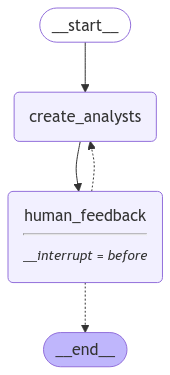

In [36]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [37]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages and integration capabilities of LangGraph. She is interested in how LangGraph can enhance AI development processes and improve system efficiencies.
--------------------------------------------------
Name: Prof. Michael Zhang
Affiliation: Global AI Ethics Consortium
Role: Ethical AI Advocate
Description: Prof. Zhang is concerned with the ethical implications of adopting new AI frameworks like LangGraph. He examines how LangGraph can promote ethical AI practices and ensure responsible AI deployment.
--------------------------------------------------
Name: Sarah Thompson
Affiliation: Enterprise Solutions Group
Role: Business Strategy Consultant
Description: Sarah Thompson analyzes the business benefits and strategic advantages of implementing LangGraph. She is interested in how LangGraph can drive innovation, reduce costs, and provide competiti

In [38]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [39]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa41e5-5e6e-6314-8002-221ffd3e25e6'}}

In [40]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages and integration capabilities of LangGraph. She is interested in how LangGraph can enhance AI development processes and improve system efficiencies.
--------------------------------------------------
Name: Prof. Michael Zhang
Affiliation: Global AI Ethics Consortium
Role: Ethical AI Advocate
Description: Prof. Zhang is concerned with the ethical implications of adopting new AI frameworks like LangGraph. He examines how LangGraph can promote ethical AI practices and ensure responsible AI deployment.
--------------------------------------------------
Name: Sarah Thompson
Affiliation: Enterprise Solutions Group
Role: Business Strategy Consultant
Description: Sarah Thompson analyzes the business benefits and strategic advantages of implementing LangGraph. She is interested in how LangGraph can drive innovation, reduce costs, and provide competiti

In [41]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa41e5-80a6-66eb-8004-2854b85d37dd'}}

In [42]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [43]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [44]:
final_state.next

()

In [45]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alice Johnson
Affiliation: Tech Innovators Inc.
Role: Startup Entrepreneur
Description: Alice is a co-founder of a tech startup that focuses on developing AI-driven solutions for small businesses. Her focus is on leveraging LangGraph to enhance the scalability and efficiency of AI applications, while her concerns revolve around cost-effectiveness and rapid deployment. She is motivated by the potential for LangGraph to provide a competitive edge in the fast-paced startup environment.
--------------------------------------------------
Name: Dr. Michael Lee
Affiliation: Global Tech Solutions
Role: AI Research Scientist
Description: Dr. Lee is a leading AI researcher with a focus on agent-based frameworks. His interest in LangGraph lies in its potential to advance the field of AI by providing a robust and flexible framework for developing intelligent agents. He is concerned with the technical capabilities and the framework's ability to integrate with existing technologies. His motiva

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [46]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [47]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [48]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [49]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [50]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

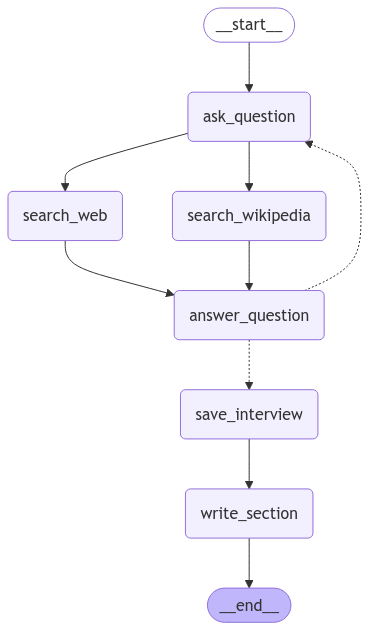

In [51]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [52]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Alice Johnson', role='Startup Entrepreneur', description='Alice is a co-founder of a tech startup that focuses on developing AI-driven solutions for small businesses. Her focus is on leveraging LangGraph to enhance the scalability and efficiency of AI applications, while her concerns revolve around cost-effectiveness and rapid deployment. She is motivated by the potential for LangGraph to provide a competitive edge in the fast-paced startup environment.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [53]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing AI Solutions for Small Businesses

### Summary

In the rapidly evolving landscape of AI-driven solutions, LangGraph emerges as a pivotal framework for small businesses aiming to leverage AI's potential. LangGraph offers a structured approach to integrating large language models (LLMs) into production-ready applications, addressing the scalability and efficiency challenges that startups often face. This framework is particularly beneficial for small businesses that require cost-effective and rapid deployment of AI solutions to maintain a competitive edge.

LangGraph's novel approach lies in its ability to manage complex, multi-step workflows through a graph-based structure. This allows for the seamless integration of multiple AI agents, each capable of performing specific tasks autonomously, such as content generation, translation, and decision-making [1][2]. By structuring these agents into a cohesive workflow, LangGraph ensures a logical and efficient flow of operations, which is crucial for small businesses that need to optimize their processes without incurring high costs [3].

One of the most interesting aspects of LangGraph is its ability to handle cyclical processes, which are essential for developing robust and scalable AI applications. This feature allows businesses to create stateful, multi-actor applications that can adapt to changing requirements and continue to function effectively over time [4]. The framework's emphasis on controllability and persistence further enhances its appeal, providing businesses with the tools needed to maintain control over their AI-driven processes while ensuring long-term sustainability [5].

LangGraph's integration with existing tools, such as Jupyter Notebooks, facilitates exploratory data analysis and model development, making it easier for startups to transition from development to deployment [6]. This integration not only streamlines the workflow but also reduces the time and resources required to bring AI solutions to market.

In summary, LangGraph represents a significant advancement in AI workflow management, offering small businesses a powerful tool to enhance their scalability and efficiency. By providing a framework that supports complex workflows and autonomous agents, LangGraph enables startups to deploy AI solutions rapidly and cost-effectively, ensuring they remain competitive in a fast-paced environment.

### Sources
[1] https://opendatascience.com/langgraph-the-future-of-production-ready-ai-agents/  
[2] https://medium.com/@abhilashkrish/optimizing-workflow-efficiency-with-langgraph-and-agents-key-features-use-cases-and-integration-6c9ae3d7f502  
[3] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[4] https://github.com/langchain-ai/langgraph  
[5] https://www.datacamp.com/tutorial/langgraph-tutorial  
[6] https://www.linkedin.com/pulse/langgraph-detailed-technical-exploration-ai-workflow-jagadeesan-n9woc  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [54]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

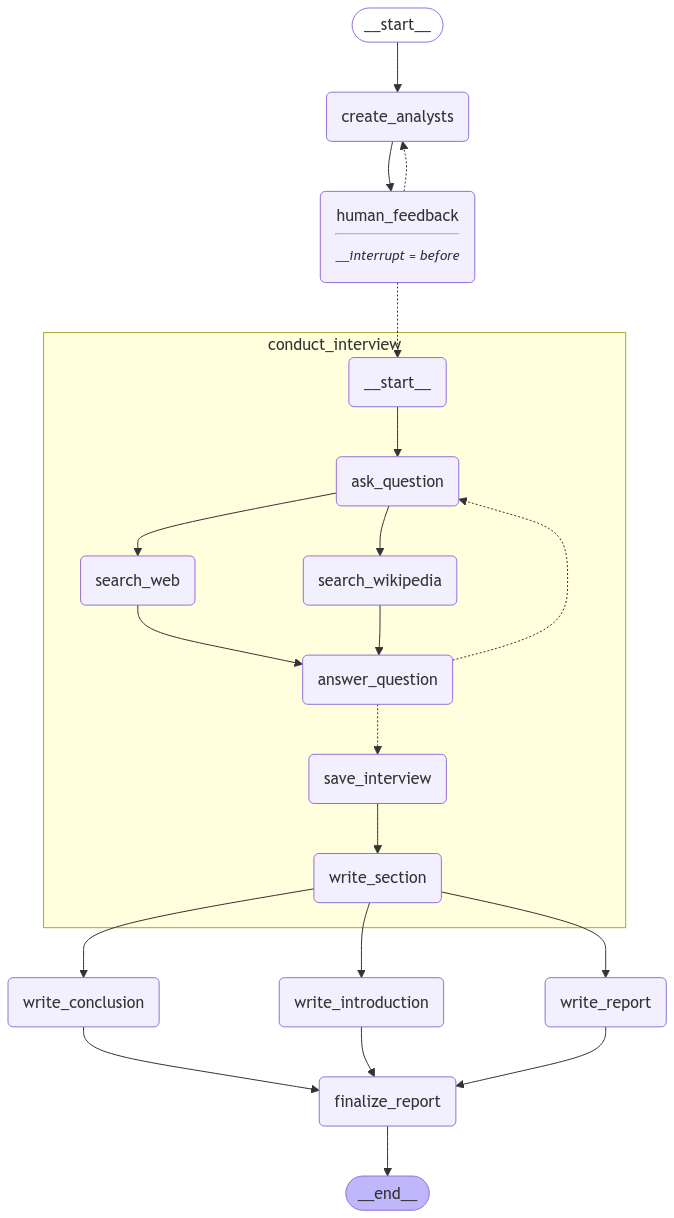

In [55]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [56]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages and integration capabilities of LangGraph. She is interested in how LangGraph can enhance AI development processes and improve system efficiencies.
--------------------------------------------------
Name: Prof. Michael Zhang
Affiliation: Global AI Ethics Consortium
Role: Ethical AI Advocate
Description: Prof. Zhang is concerned with the ethical implications of adopting new AI frameworks like LangGraph. He examines how LangGraph can promote ethical AI practices and ensure responsible AI deployment.
--------------------------------------------------
Name: Sarah Thompson
Affiliation: Enterprise Solutions Group
Role: Business Strategy Consultant
Description: Sarah Thompson analyzes the business benefits and strategic advantages of implementing LangGraph. She is focused on how LangGraph can drive business growth, improve ROI, and provide competit

In [57]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa41e6-ba3a-6c44-8002-219b4c46dd8b'}}

In [58]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages and integration capabilities of LangGraph. She is interested in how LangGraph can enhance AI development processes and improve system efficiencies.
--------------------------------------------------
Name: Prof. Michael Zhang
Affiliation: Global AI Ethics Consortium
Role: Ethical AI Advocate
Description: Prof. Zhang is concerned with the ethical implications of adopting new AI frameworks like LangGraph. He examines how LangGraph can promote ethical AI practices and ensure responsible AI deployment.
--------------------------------------------------
Name: Sarah Thompson
Affiliation: Enterprise Solutions Group
Role: Business Strategy Consultant
Description: Sarah Thompson analyzes the business benefits and strategic advantages of implementing LangGraph. She is focused on how LangGraph can drive business growth, improve ROI, and provide competit

In [59]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa41e6-d222-6c71-8004-4bcb46c1e7bb'}}

In [60]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [61]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Embracing LangGraph: A New Era in AI Development

## Introduction

In the dynamic world of artificial intelligence, LangGraph is emerging as a transformative framework, offering unparalleled scalability, flexibility, and integration capabilities. This report explores how LangGraph revolutionizes AI development by enabling the creation of stateful, multi-actor applications with large language models (LLMs). With its graph-based approach, LangGraph provides deep insights into data connections, empowering developers to make informed, data-driven decisions. Its robust integration features, including structured outputs and caching, enhance performance and adaptability across various applications. By comparing LangGraph with other frameworks, this report highlights its unique advantages, making it an essential tool for tech companies and startups aiming to streamline AI development and gain a competitive edge.

---



LangGraph is emerging as a transformative framework in the AI development landscape, offering significant advantages in scalability, flexibility, and integration capabilities. It is particularly beneficial for startups and tech companies looking to streamline their AI development processes and improve operational efficiency. LangGraph provides a comprehensive solution for building stateful, multi-actor applications with large language models (LLMs), thereby transforming how AI solutions are evaluated and optimized [1].

One of the most novel aspects of LangGraph is its graph-based approach, which facilitates the visualization and management of complex interactions. This feature is especially advantageous for projects requiring deep insights into data connections, making LangGraph an excellent choice for sophisticated data relationship analysis [2]. The framework's ability to offer granular control over an agent's thought process empowers developers to make data-driven decisions tailored to diverse needs [3].

LangGraph's integration capabilities are further enhanced by its extensive support for structured outputs and caching mechanisms, which improve performance and ensure contextual awareness over time. This makes LangGraph not only scalable but also highly adaptable to various AI applications, from content generation to customer support [4]. Additionally, LangGraph's comprehensive documentation and support for open-source LLMs make it accessible and customizable, catering to a wide range of development requirements [5].

In comparison to other frameworks like Autogen and Crew AI, LangGraph stands out for its multi-agent pattern support and replay functionalities, which are crucial for debugging and managing complex workflows. While Autogen excels in ease of use due to its conversational approach, LangGraph's structured role-based design and efficient interaction management among multiple agents provide a competitive edge [6].

For startups, LangGraph offers unique advantages that can empower them to compete with established players. Its ability to create controlled, production-ready AI applications bridges the gap between the potential of LLMs and the practical requirements of real-world software development [1]. This capability is crucial for startups that need to quickly develop and deploy AI solutions without the extensive resources typically available to larger companies.

LangGraph's support for cycles, controllability, and persistence is essential for agentic architectures, allowing startups to define complex workflows that can adapt and evolve over time [2]. This flexibility and robustness are often lacking in other frameworks. Moreover, LangGraph's advanced workflow control and state management capabilities enable startups to ensure quality in function calling and customize message types and parameters [3].

The framework also facilitates the creation of versatile AI agents, such as chatbots, that can manage conversation states, escalate complex queries, and explore alternative conversation paths through its innovative time-travel feature [4]. This functionality enhances user experience and allows startups to experiment with different interaction models and optimize their solutions based on real-time feedback.

Despite the challenges of managing data flows and processing tasks within applications, LangGraph's benefits in a startup environment are substantial. Its ability to streamline AI workflow management and facilitate the creation of dynamic applications positions it as a valuable asset for startups aiming to leverage AI for competitive advantage. As AI continues to permeate various industries, tools like LangGraph will play a pivotal role in shaping the future of AI-driven innovation.


---

## Conclusion

LangGraph is revolutionizing AI development by offering unparalleled scalability, flexibility, and integration capabilities. Its graph-based approach and support for multi-agent patterns provide developers with deep insights and control, making it an ideal choice for complex data relationship analysis and sophisticated AI applications. For startups, LangGraph lowers entry barriers and accelerates innovation, enabling rapid development of production-ready solutions. Despite challenges in managing data flows and ensuring workflow reliability, LangGraph's comprehensive toolset and integration capabilities position it as a valuable asset for both established tech companies and emerging AI startups. As AI continues to evolve, LangGraph stands out as a pivotal framework driving efficiency and innovation.

## Sources
[1] https://www.langchain.com/langgraph  
[2] https://www.curotec.com/insights/langchain-vs-langgraph-framework-comparison/  
[3] https://opendatascience.com/langgraph-the-future-of-production-ready-ai-agents/  
[4] https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4  
[5] https://www.galileo.ai/blog/mastering-agents-langgraph-vs-autogen-vs-crew  
[6] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[7] https://github.com/langchain-ai/langgraph  
[8] https://medium.com/@hao.l/why-langgraph-stands-out-as-an-exceptional-agent-framework-44806d969cc6  
[9] https://devendrabogati.medium.com/building-a-versatile-ai-chatbot-with-langgraph-a-step-by-step-guide-10047893972d  
[10] https://blog.langchain.dev/customers-tradestack/  
[11] https://medium.com/@tamoghnadas.12/create-llm-powered-apps-with-langgraph-fastapi-streamlit-fa6ceb606454  
[12] https://www.gettingstarted.ai/langgraph-tutorial-with-example/

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r